In [ ]:
% matplotlib inline 

In [ ]:
import matplotlib.pylab as plt

In [3]:
import scipy.signal as signal
import numpy as np 
import os, csv

In [4]:
def load_data(subject_id, day, listen=0): 
    """inputs: 'day' = int [1 OR 2]
    returns a list of all subjects in gaze directory matching 'day'"""

    data_file_names = []
    data_path = '../../collection/gaze_data/'
    folder_contents = os.listdir(data_path)
    
    for file in folder_contents: 
        if 'd%s.asc'%day in file and not 'x' in file: 
            data_file_names.append(file)
                
    for file_name in data_file_names: 
        if subject_id in file_name: 
            subject_path = data_path + file_name
            if listen: print("loading data from subject'%s'"%file_name) 

    with open(subject_path) as f:
        reader = csv.reader(f, delimiter="\t")
        subject_data = list(reader)

    return subject_data

def extract_data(subject_id='12', day=1): 
    """ 
    inputs: 'subject_data' = raw ascii file 
    returns: np.arrays for pupil, CS+, CS-, US, and movie_frame information 
    
    """
    subject_data = load_data(subject_id, day)


    _pupil_ = [] ; xy = []
    cs_pos = []; cs_p = 0 # CS+
    cs_neg = []; cs_n = 0 # CS-
    us_sti = []; us_o = 0 # US

    # movie frame data prep 
    m_frame, i_frame = [], np.nan

    for i_row in range(len(subject_data)): 

        msg = subject_data[i_row]  

        try: 
            int(subject_data[i_row][0])
            # 3 = pupil column
            datum = float(msg[3]) 
            _pupil_.append(datum)
            cs_pos.append(cs_p)
            cs_neg.append(cs_n)
            us_sti.append(us_o)
            m_frame.append(i_frame)
            
            # extract xy coordinates 
            if ' .' in msg[1] or ' .' in  msg[2]:
                xy.append([np.nan, np.nan])
            else: 
                xy.append([float(msg[1]), float(msg[2])])
            

        except: 

            if len(msg) > 1: 
                if 'CS+' in msg[1]: cs_p = 1
                if 'CS-' in msg[1]: cs_n = 1
                if 'US'  in msg[1]: us_o = 1
                if 'OFF' in msg[1]: 
                    cs_p = 0
                    cs_n = 0
                    us_o = 0 

                if msg[0] == "MSG": 

                    if "VFRAME" in msg[1]: 

                        ind = str.find(msg[1], "VFRAME")
                        space = str.find(msg[1], " 0 0 /")
                        i_frame = int(msg[1][ind+7:space])

    return np.array(_pupil_), np.array(cs_pos), np.array(cs_neg), np.array(us_sti), np.array(m_frame), np.array(xy)


def find_derivative(_pupil_): 
    """determined the change in pupil size across an interval set by 'skip'"""

    # initiate data structures
    indices = []
    skip = 5 
    dp_dt = np.zeros(len(_pupil_))

    # define blink as time when no measurements taken--super conservative
    blink_segment = np.repeat(np.nan, len(_pupil_))
    blink_segment[_pupil_==0] = 1 * np.mean(_pupil_)

    # take interval if we're subsampling the data (to get bigger deltas)
    sliced_segment = _pupil_[::skip]
    index_segment = np.array(list(range(len(_pupil_)))[0::skip])

    # preserve the length of the segment, even if we're subsampling
    for ii in range(1, len(sliced_segment)): 
        dp_dt[index_segment[ii]] = sliced_segment[ii] - sliced_segment[ii-1]

    return abs(dp_dt), blink_segment


def define_blinks(_pupil_, set_thresh=500): 
    """determine when blinks occur in timecourse"""

    conv_filter_length=20
    
    blink = np.repeat(np.nan, len(_pupil_))
    
    # extract change in pupil size and a naive blink measure
    delta, naive_blink = find_derivative(_pupil_)

    # fill zero space inside derivative with arbitrary value (to sum later)
    delta[naive_blink==naive_blink] = 1
    
    # another way to do this is to add the colvolution of naive and delta together -- more interpretable
    _delta_ = np.convolve(delta,np.ones(conv_filter_length), 'same')[0:len(delta)]

    # inherit naive locations
    blink[naive_blink > 0] = 1

    # inherit edges  
    blink[_delta_ > set_thresh] = 1
    
    #blink[blink == blink] = 1
    
    return blink, _pupil_


def find_boundaries(_blink_):
    
    # convert to zeros if was nan
    if _blink_[0] != _blink_[0]: 
        _blink_[_blink_!=_blink_] = 0 
    
    # convolve with an edge detector 
    kernel = [1, -1]
    edges = np.convolve(_blink_, kernel)
    
    # find location of onsets and offsets in the timecourse
    onsets, offsets = np.nonzero(edges > 0 )[0], np.nonzero(edges < 0)[0]
    
    return onsets, offsets


def interpolate(pupil, blinks, window_size=5, show=0, order=5): 
    """
    interpolate between data missing due to blinks, etc. 
    inputs: 
        
        _pupil_ = pupil data  
        blink = blink data
        window_size=5
        show= [1,0] 

    outputs: 
    
        fill_blinks: len(vector of NaNs) = len(_pupil_) with interpolated data at indices of blinks     
        edge_blinks: len(vector of NaNs) = len(_pupil_) with edges used to generate interpolation
    
    """
    # set blinks to NaNs in pupil timecourse
    _pupil_ = np.copy(pupil)
    _pupil_[blinks==1] = np.nan

    # generate indices for pupil measurements
    x_range = np.arange(len(_pupil_))
    
    # identify "blink" onsets and offsets
    onsets, offsets = find_boundaries(blinks)

    # generate data structure for blink fills 
    fill_blinks = np.repeat(np.nan, len(x_range))
    edge_blinks = np.repeat(np.nan, len(x_range))
    
    # edge around blink to include in polynomial fit 
    window_size = window_size 
    
    if show: plt.figure(figsize=[15,4]) 
        
    for i_blink in range(len(offsets)): 

        # define n_inds to include around "blink"
        fit_ons = onsets[i_blink] - window_size 
        fit_off = offsets[i_blink] + window_size

        # extract interval polynomial will be fit to
        x_short = x_range[fit_ons:fit_off]
        y_short = _pupil_[fit_ons:fit_off]

        # find polynomial fit to window around "blink" 
        edge_function = np.polyfit(x_short[y_short==y_short], y_short[y_short==y_short], order)
        function_ = np.poly1d(edge_function)
        i_fill_blink = function_(x_short)[window_size:-window_size]

        fill_blinks[onsets[i_blink]:offsets[i_blink]] = i_fill_blink
        edge_blinks[fit_ons:fit_off] = _pupil_[fit_ons:fit_off]

        if show: 

            empty_set_ref = np.repeat(np.nan, len(x_range))
            empty_set_ref[fit_ons:fit_off] = _pupil_[fit_ons:fit_off]
            empty_set_inter = np.repeat(np.nan, len(x_range))
            empty_set_inter[onsets[i_blink]:offsets[i_blink]] = i_fill_blink

            plt.subplot(1,2,i_blink+1)
            plt.plot(x_range, _pupil_, 'b', alpha=.2, linewidth=4)
            plt.scatter(x_range[empty_set_ref==empty_set_ref],empty_set_ref[empty_set_ref==empty_set_ref], marker='o', s=20)

            plt.plot(x_range, empty_set_inter, 'm', alpha=.5, linewidth=5)

            plt.legend(['   "pupil" data', '  polynomial fit', 'edges used to \n fit polonomial'], prop={'size': 10})
            plt.title("polynomial fit to 'blink' %s\n"%i_blink);
            plt.axis('off')

    return fill_blinks, edge_blinks


def filter_data(input_data, start_int=0, len_int=10000, filter_order=2, lowpass_cutoff=0.00001, highpass_cutoff=.01, show=0): 
    
    # First, design the Buterworth filter to extract lowest frequency variation - a better mean, basically, to subtract
    B_1, A_1= signal.butter(filter_order, lowpass_cutoff, output='ba') 
    low_freq = signal.filtfilt(B_1,A_1, input_data)

    # extract the frequency range of likely motion artifacts
    B_2, A_2 = signal.butter(filter_order, highpass_cutoff, output='ba') 
    below_high = signal.filtfilt(B_2, A_2, input_data)
    filtered_data = below_high - low_freq

    # zscore the filtered data
    filtered_data = (filtered_data-np.mean(filtered_data))/np.std(filtered_data)
    low_pass_filtered = (below_high-np.mean(below_high))/np.std(below_high)
    
    if start_int: 
        end_int = start_int + len_int
    else: 
        start_int = 0
        end_int = len(input_data)
        

    def slice_data(data_in,start_int, end_int): 
        return data_in[start_int:start_int+end_int]
    
    _filter_ = {}
    _filter_['input_data'] = input_data = slice_data(input_data, start_int, end_int)
    _filter_['low_freq'] = low_freq = slice_data(low_freq, start_int, end_int)
    _filter_['below_high'] = below_high = slice_data(below_high, start_int, end_int)
    _filter_['pupil'] = filtered_data = slice_data(filtered_data, start_int, end_int)
    _filter_['low_pass_filt'] = low_pass_filtered = slice_data(low_pass_filtered, start_int, end_int)
    

    if show: 
        plt.figure(figsize=(20,3)); plt.axis('off'); 
        plt.plot(input_data, 'xkcd:blue',alpha=.4, linewidth=3)
        plt.plot(low_freq, 'xkcd:red',alpha=.2,linewidth=6)
        plt.plot(below_high,'indigo',linewidth=1,alpha=.7)
        plt.legend(['original','low pass filter','high pass filtered'])
        plt.title('bandpass procedure on blink corrected pupil data')
        plt.figure(figsize=(20,3)); plt.axis('off'); 
        plt.ylim([min(filtered_data)-.25,max(filtered_data)+.25]); 
        plt.xlim([0,len(filtered_data)])  
        plt.plot(filtered_data,'indigo',linewidth=3,alpha=.7,color='xkcd:blue')
        plt.title('\noutput: bandpass filtered data')
    
    return _filter_


In [5]:
def nice_lines(data, name, color='m', heavy=[.6, 2], light=[.1, 12]): 
    
    plt.plot(data, color, alpha=heavy[0], linewidth=heavy[1], label=name)    
    plt.plot(data, color, alpha=light[0], linewidth=light[1])
    

In [6]:
# not using these at this point, but incorporate it soon

def set_params(): 
    
    params = {}
    
    # load params
    params['subject_id'] = '12'
    params['day'] = 1
    
    # definition of blink params
    params['blink_thresh'] = 1000
    params['conv_filter_length'] = 20
    params['window_size'] = 4 
    
    # interpolation params
    params['order'] = 1
    
    # band pass filter params
    params['lowpass_cutoff'] = 0.00001
    params['highpass_cutoff'] =.01
    
    return params

In [7]:
def preprocess_pupil_data(subject_id='12', day=1): 
    
    e = {'params': set_params()}

    e['raw'], e['CS+'], e['CS-'], e['US'], e['mov'], e['xy'] = extract_data(subject_id, day)

    # define blink times
    e['blinks'], e['pupil'] = define_blinks(e['raw'], set_thresh=e['params']['blink_thresh'])

    # extract onsets and offsets
    e['onsets'], e['offsets'] = find_boundaries(e['blinks'])

    # interpolate betwen blinks -- edges are just for visualization
    interpolation, edges = interpolate(e['raw'], e['blinks'], window_size=20, order=e['params']['order'])

    # fill gaps 
    e['pupil'][interpolation == interpolation] = interpolation[interpolation == interpolation]

    # bandpass filter
    e['filtered'] = filter_data(e['pupil'], lowpass_cutoff=0.0003)

    # deal with annoying overwrite
    e['raw'] = extract_data()[0]
    
    return e, edges, interpolation

In [ ]:
e, edges, interpolation = preprocess_pupil_data();  print('data: ', list(e.keys()))

In [ ]:
# for ease plotting
x_range = np.arange(0, len(e['pupil']))

start, end = 1000, 15000
# FIGURE ONE: plot original data (without the blink)
plt.figure(figsize=(20,3)); plt.axis('off'); 
plt.plot(x_range, e['raw'], 'b', alpha=.2, linewidth=4)
# plot the edges used to generate interpolation
plt.scatter(x_range[edges==edges],edges[edges==edges], marker=(5, 0), s=20)
# plot interpolation between edges
plt.plot(x_range, interpolation, 'm', alpha=.5, linewidth=5)
# aesthetics 
plt.legend(['   "pupil" data', '  polynomial fit', '  edges used to \n  fit polonomial'], prop={'size': 10}, loc=1)
plt.title("polynomial fit (order = %s) to 'blinks'\n"%e['params']['order']);
plt.xlim([start,end])

# FIGURE TWO: blink corrected timecourse
plt.figure(figsize=(20,3)); plt.axis('off'); 
nice_lines(e['pupil'], color='b', name='') 
plt.title('blink-corrected pupil timecourse')
plt.xlim([start,end])

# prep for FIGURE THREE: band pass filtering
_low_ = np.array(e['filtered']['low_freq'])
_high_ = np.array(e['filtered']['below_high'])
_filt_ = np.array(e['filtered']['pupil'])

# FIGURE THREE: band pass filtering
plt.figure(figsize=(20,3)); plt.axis('off'); 
plt.plot(e['pupil'], 'xkcd:blue',alpha=.4, linewidth=3)
plt.plot(_low_, 'xkcd:red',alpha=.2,linewidth=6)
plt.plot(_high_,'indigo',linewidth=1,alpha=.7)
plt.legend(['original','low pass filter','high pass filtered'])
plt.title('bandpass procedure on blink corrected pupil data')
plt.xlim([start,end])

# FIGURE FOUR: final pupil timecourse 
plt.figure(figsize=(20,3)); plt.axis('off'); 
plt.ylim([min(_filt_)-.25,max(_filt_)+.25]); 
#plt.xlim([0,len(_filt_)])  
plt.plot(_filt_,'indigo',linewidth=2,alpha=.5,color='xkcd:blue')
plt.title('\nfinal output: bandpass filtered blink corrected data'); 
plt.xlim([start,end]); 

> longer intervals aren't blinks. it would be interesting to see if the mean fluctions are driven by luminance--i.e. gaze shifting to the (white) screen. also, building in regressors for relative luminance might be interesting + easy. 

> that is, using RGB values determined by the gaze position with  

> $$Y=0.2126R+0.7152G+0.0722B$$

> 

In [10]:
def for_show(inputs):
    
    inputs = np.array(inputs)
    tmp_ = np.repeat(np.nan, len(inputs))
    tmp_[inputs != 0] = 1  
    
    return tmp_

In [ ]:
start, end = 2000, 50000

plt.figure(figsize=(20,3)); plt.axis('off')
plt.plot(e['raw'][start:end], 'xkcd:blue',alpha=.4, linewidth=3)
plt.title('raw pupil data')

plt.figure(figsize=(20,3)); plt.axis('off')
plt.plot(e['pupil'][start:end], 'xkcd:blue',alpha=.4, linewidth=3)
plt.plot(_low_[start:end], 'xkcd:red',alpha=.2,linewidth=6)
plt.plot(_high_[start:end],'indigo',linewidth=1,alpha=.7)
plt.legend(['original','low pass filter','high pass filtered'])
plt.title('bandpass procedure on blink corrected pupil data')

plt.figure(figsize=[20,4]) ; plt.axis('off'); 
nice_lines(e['filtered']['pupil'][start:end],color='b', name='pupil', heavy=[.2, 1], light=[.1, 10])
nice_lines(for_show(e['blinks'][start:end]),color='k-', name='blink', heavy=[1, 5])
plt.title('band pass filtered pupil data + stimuli and blinks'); plt.legend(loc = 4); 

In [ ]:
plt.figure(figsize=[20,4]) ; plt.axis('off'); 
nice_lines(e['filtered']['pupil'][start:end],color='b', name='pupil', heavy=[.2, 1], light=[.1, 10])
nice_lines(for_show(e['CS+'][start:end]),color='r', name='CS+', heavy=[.4, 2])
nice_lines(for_show(e['CS-'][start:end]),color='xkcd:blue', name='CS-', heavy=[.4, 2])
nice_lines(for_show(e['US'][start:end]), color='r', name='US', heavy=[.5, 8])
nice_lines(for_show(e['blinks'][start:end]),color='k-', name='blink', heavy=[1, 5])
plt.legend(prop={'size': 11}, loc=3)
plt.ylim([-8,8]); 

In [ ]:
start, end = 0, 13000

fps = round(len(np.nonzero(e['CS+'][start:end])[0])/4)
length_s = len(e['pupil']) / fps
x_range = np.arange(0, length_s, 1/(fps))

print("but it's %s frames per second  ... whaaaat the fuck?"%fps)

In [8]:
e, edges, interpolation = preprocess_pupil_data('05', day=2);  print('data: ', list(e.keys()))

data:  ['params', 'raw', 'CS+', 'CS-', 'US', 'mov', 'xy', 'blinks', 'pupil', 'onsets', 'offsets', 'filtered']


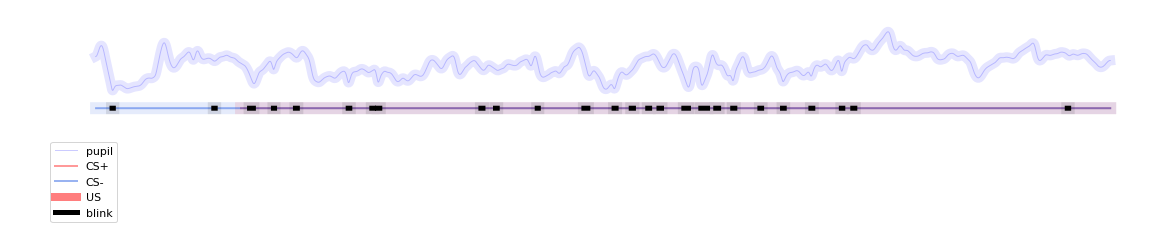

In [11]:
start, end = 0, -1

plt.figure(figsize=[20,4]) ; plt.axis('off'); 

nice_lines(e['filtered']['low_pass_filt'][start:end]+5,color='b', name='pupil', heavy=[.2, 1], light=[.1, 10])
nice_lines(for_show(e['CS+'][start:end]),color='r', name='CS+', heavy=[.4, 2])
nice_lines(for_show(e['CS-'][start:end]),color='xkcd:blue', name='CS-', heavy=[.4, 2])
nice_lines(for_show(e['US'][start:end]), color='r', name='US', heavy=[.5, 8])
nice_lines(for_show(e['blinks'][start:end]),color='k-', name='blink', heavy=[1, 5])

plt.legend(prop={'size': 11}, loc=3)
plt.ylim([-10,10]); 

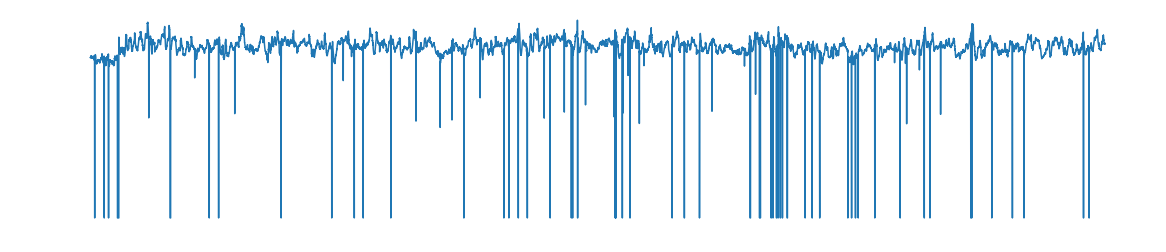

In [12]:
plt.figure(figsize=[20,4]) ; plt.axis('off'); 
plt.plot(e['raw'])

In [ ]:
["n03223299_17531.JPEG","n03223299_7692.JPEG","n03223299_5702.JPEG","n03223299_8603.JPEG","n03223299_2994.JPEG"]
["n03223299_6337.JPEG","n03223299_5702.JPEG","n03223299_17531.JPEG","n03223299_6897.JPEG","n03223299_4481.JPEG"]

"n03223299_17531.JPEG", 
"n03223299_17531.JPEG"
"n03223299_5702.JPEG", 
"n03223299_5702.JPEG"